# Georgia Tech Face Database with Tensorflow and Keras
This model looks at using better labeled, more varied data than the vanilla model in order to more effectively estimate the location of a person's nose.

Data source: [here](http://www.anefian.com/research/face_reco.htm).

## Installation
We first need to install TensorFlow 1.12 because TensorFlow 1.13 countains a BatchNormalizationV1 layer that cannot be converted to TensorFlowJS

In [1]:
!pip install tensorflow==1.12

    100% |████████████████████████████████| 83.1MB 279kB/s 
    100% |████████████████████████████████| 3.1MB 6.0MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


## Imports

In [183]:
from __future__ import absolute_import, division, print_function

import os
import re

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from google.colab import files
from google.colab import drive

%matplotlib inline

TensorFlow version is  1.12.0


## Data Preprocessing
We now need to import the data and format it for Keras.

### Access Data
We need to load the image and pose data from Google Drive

In [3]:
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/gt_db/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Extract Nose Center
Now, let us create methods to actually extract the center of the image and try it out

In [0]:
def img2txt_name(f):
    '''
    Using the image filename, find the filename with the pose information
    '''
    return data_path + str(f)[:-4] + '.txt'

def get_ctr(f):
    '''
    Using the filename of the image, get the coordinates of the center of the face
    '''
    return np.genfromtxt(img2txt_name(f))

def get_scaled_center(f, img_shape, x_offset, y_offset):
    '''
    Scale the coordinates so that they correspond to the locations in the scaled image
    '''
    img = cv2.imread(data_path + f)
    pt = get_ctr(f)
    return np.array([(pt[0] - x_offset) * (img_shape / (img.shape[1] - x_offset * 2)), 
                     (pt[1] - y_offset) * (img_shape / (img.shape[0] - y_offset * 2))])

560


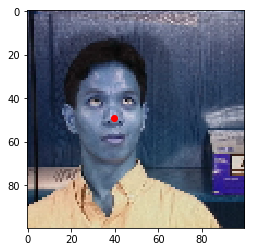

In [111]:
fname = 's04/02.jpg'
img = cv2.imread(data_path + fname)
plt.imshow(cv2.resize(img[:,80:560,:], (100, 100)))
print(img.shape[1] - 80)
ctr = get_scaled_center(fname, 100, 110, 0)
plt.scatter([ctr[0]], [ctr[1]], c='r')

### Create Training and Validation Arrays
Note that right now, the data from directory s05 is being used for validation arbitrarily. This can always be changed later.

In [0]:
valid_dirs = ['s05']
train_dirs = [dir for dir in os.listdir(data_path) if len(dir) == 3 and dir not in valid_dirs]

In [0]:
def extract_from_dir(dir, dim):
    '''
    From a directory, load in all of the images and their corresponding poses
    in the correct format. It returns a list of images and a list of labels where
    the index for the corresponding data points is the same
    '''
    # Extract image filenames (we are only using some to reduce RAM usage)
    pattern = re.compile('.*jpg')
    all_img_fns = [dir + '/' + fn for fn in os.listdir(data_path + dir) 
                   if pattern.match(fn)]
    img_fns = all_img_fns 
    # img_fns =  np.random.choice(np.array(all_img_fns), size=200, replace=False)
  
    # Now build the data and labels arrays
  
    # First declare them, so we won't have to resize anything
    data = np.zeros((len(img_fns), dim, dim, 3)).astype(int)
    labels = np.zeros((len(img_fns), 2))
  
    # Now fill in the arrays
    for i in range(len(img_fns)):
        # Read in the image
        img = cv2.imread(data_path + img_fns[i])
    
        # Make it into a square
        size = min(img.shape[0], img.shape[1])
        x_offset = (img.shape[1] - size) // 2
        y_offset = (img.shape[0] - size) // 2
        
        if (y_offset == 0):
            square = img[:,x_offset:-x_offset,:]
        else:
            square = img[y_offset:-y_offset,:,:]
    
        # Fill the final array
        data[i] = cv2.resize(square, (dim, dim))
        
        # Now get the label
        labels[i] = get_scaled_center(img_fns[i], dim, x_offset, y_offset)
        
    
    return data, labels

def extract_data(dirs, dim):
    '''
    For each directory in the list, get the data and labels
    '''
    # Declare the arrays we will use
    data = np.zeros((0, dim, dim, 3)).astype(int)
    labels = np.zeros((0, 2))
  
    # For each directory, append on the data
    for dir in dirs:
        d_tmp, l_tmp = extract_from_dir(dir, dim)
        data = np.append(data, d_tmp, axis=0)
        labels = np.append(labels, l_tmp, axis=0)
    
    return data, labels

Now, before we can actually extract the data, we need to set how large the images are going to be, post-resizing

In [0]:
image_size = 160

In [0]:
data_train, labels_train = extract_data(train_dirs, image_size)
data_valid, labels_valid = extract_data(valid_dirs, image_size)

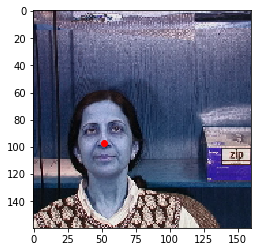

In [115]:
plt.imshow(data_valid[12])
pts = labels_valid[12]
plt.scatter([pts[0]], [pts[1]], c='r')

### Create Image Data Generator with Image Augmentation
We then need to resize the images and create a data generator, to be used for training / validation

For this section, I used an additional source: [here](https://keras.io/preprocessing/image/)

In [0]:
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(data_train, labels_train,
                batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow(data_valid, labels_valid,
                batch_size=batch_size)

## Train the Model
### Create the base model using a pretrained network
Here we are using MobileNet, because that is what was used in the course. It can always be changed later

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model ResNet
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                            input_shape=IMG_SHAPE, 
                                            weights='imagenet')

## Model Set-Up
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

### Add back the top layers
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation=tf.keras.activations.relu),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(2)
])

### Compile the model
You must compile the model before training it. For this, we will create a new metric, the distance between the ground-truth point and our point

In [0]:
def dist_pred(y_true, y_pred):
    return K.sqrt((y_true[0] - y_pred[0])**2 + (y_true[1] - y_pred[1])**2)

In [0]:
lr = 0.0001 # 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


###Train Final Layers

In [0]:
def train(lr, epochs):
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])
  steps_per_epoch = train_generator.n // batch_size
  validation_steps = max(validation_generator.n // batch_size, 1)

  history = model.fit_generator(train_generator, 
                                steps_per_epoch = steps_per_epoch,
                                epochs=epochs, 
                                workers=4,
                                validation_data=validation_generator, 
                                validation_steps=validation_steps)

In [162]:
epochs = 1
lr = 0.001 # 0.0001
train(lr, epochs)

Epoch 1/1
22/22 [==============================] - 62s 3s/step - loss: 646.0317 - dist_pred: 26.2734 - val_loss: 953.5222 - val_dist_pred: 19.8255


In [128]:
epochs = 1
lr = 0.0001 # 0.0001
train(lr, epochs)

Epoch 1/1
22/22 [==============================] - 52s 2s/step - loss: 114.8255 - dist_pred: 15.6093 - val_loss: 618.0236 - val_dist_pred: 21.0153


[[82.06763  84.985794]]


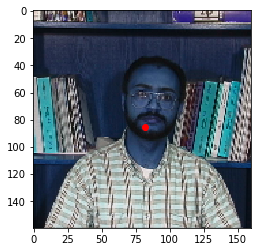

In [164]:
ctr = model.predict(np.expand_dims(data_train[30], axis=0))
plt.imshow(data_train[30])
print(ctr)
plt.scatter([ctr[0][0]], [ctr[0][1]], c='r')

### Train All Layers

In [0]:
base_model.trainable = True

In [165]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [166]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


In [167]:
epochs = 1
lr = 0.0000001 # 0.0001
train(lr, epochs)

Epoch 1/1
22/22 [==============================] - 62s 3s/step - loss: 174.9298 - dist_pred: 16.4244 - val_loss: 925.2236 - val_dist_pred: 25.5473


In [138]:
epochs = 1
lr = 0.000001 # 0.0001
train(lr, epochs)

Epoch 1/1
22/22 [==============================] - 204s 9s/step - loss: 96.4120 - dist_pred: 14.6836 - val_loss: 586.1015 - val_dist_pred: 44.2657


## Sandbox

In [182]:
image = cv2.imread(data_path + 's04/02.jpg')
grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/haarcascade_frontalface_default.xml')
bounding_boxes = face_cascade.detectMultiScale(grayscale_image, 1.25, 6)
bounding_boxes

array([[175, 128, 187, 187]], dtype=int32)

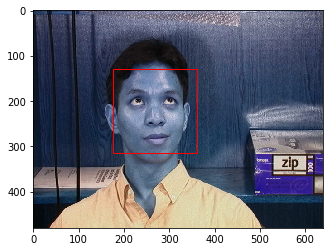

In [186]:
box = bounding_boxes[0]
fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)